## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Compute the camera calibration using chessboard images


In [1]:
import glob
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def detectCorners(img, nx, ny):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    return ret, corners

def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def calibrate():
    nx = 9
    ny = 6

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Get object points and image points and draw points on image
    for file in glob.glob('./camera_cal/calibration*.jpg'):
        cvImage = cv2.imread(file)
        fname = file.split('/')[-1]
        ret, corners = detectCorners(cvImage, nx, ny)
        if (ret == True):
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.imwrite('./camera_cal_with_points/' + fname, cvImage)
            
    img = cv2.imread('./camera_cal/calibration1.jpg')
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate()


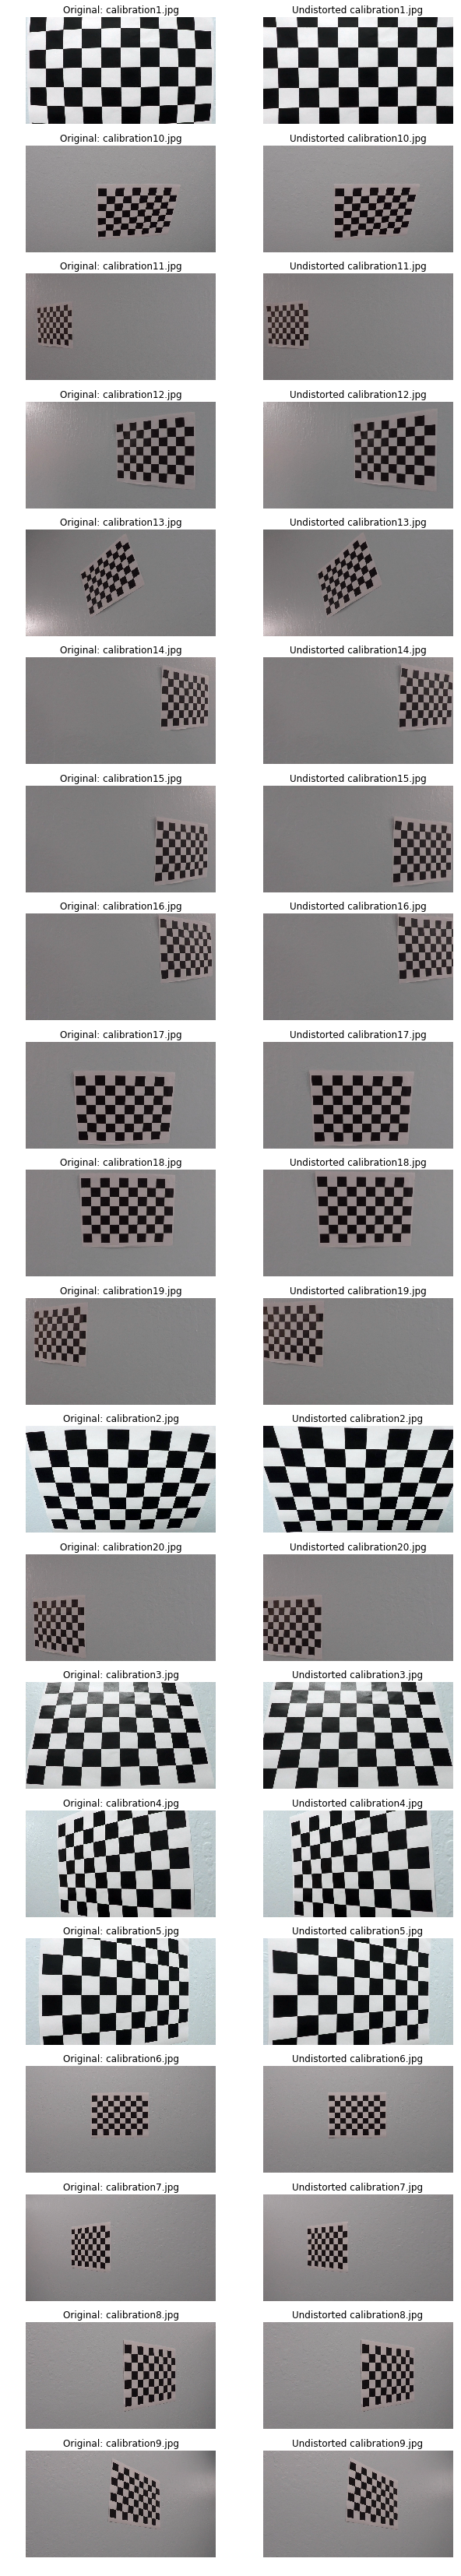

In [2]:
# Test calibration

fig, axs = plt.subplots(20, 2, figsize=(10, 60))
axs = axs.ravel()
i = 0
for file in glob.glob('./camera_cal/calibration*.jpg'):
    cvImage = cv2.imread(file)
    fname = file.split('/')[-1]
    dst = undistort(cvImage)
#     cv2.imwrite('./undistorted/' + fname, dst)

    # Plot before images
    axs[i].axis('off')
    axs[i].set_title('Original: ' + fname)
    axs[i].imshow(cvImage)

    # Plot after image
    axs[i + 1].axis('off')
    axs[i + 1].set_title('Undistorted ' + fname)
    axs[i + 1].imshow(dst)
    i = i + 2


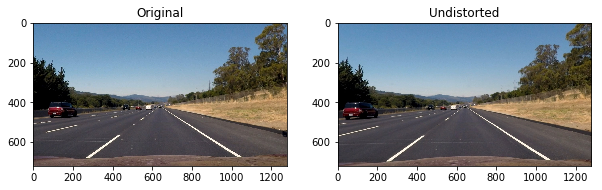

In [3]:
# Test Image calibration

fig, axs = plt.subplots(1, 2, figsize=(10, 60))
axs = axs.ravel()

cvImage = mpimg.imread('./test_images/straight_lines2.jpg')
axs[0].imshow(cvImage)
axs[0].set_title('Original')
dst = undistort(cvImage)
axs[1].imshow(dst)
axs[1].set_title('Undistorted')

# Select Region of Interest From Image

In [4]:
def getRegion(img):
    region = np.array(
        [
            [
                (500, 460), 
                (790, 460),
                (1150,720),
                (150,720)
            ]
        ], 
        dtype=np.int32
    )
    return region

def regionOfInterest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    region = getRegion(img)
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "region" with the fill color    
    cv2.fillPoly(mask, region, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


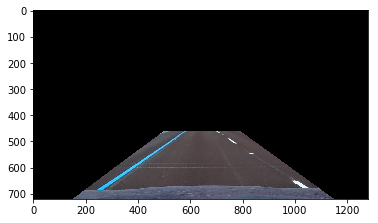

In [5]:
# Test region of interest

def testROI():
    img = cv2.imread('./test_images/straight_lines1.jpg')

    newImg = regionOfInterest(img)
    plt.imshow(newImg)
    
testROI()

# Create a Thresholded Binary Image

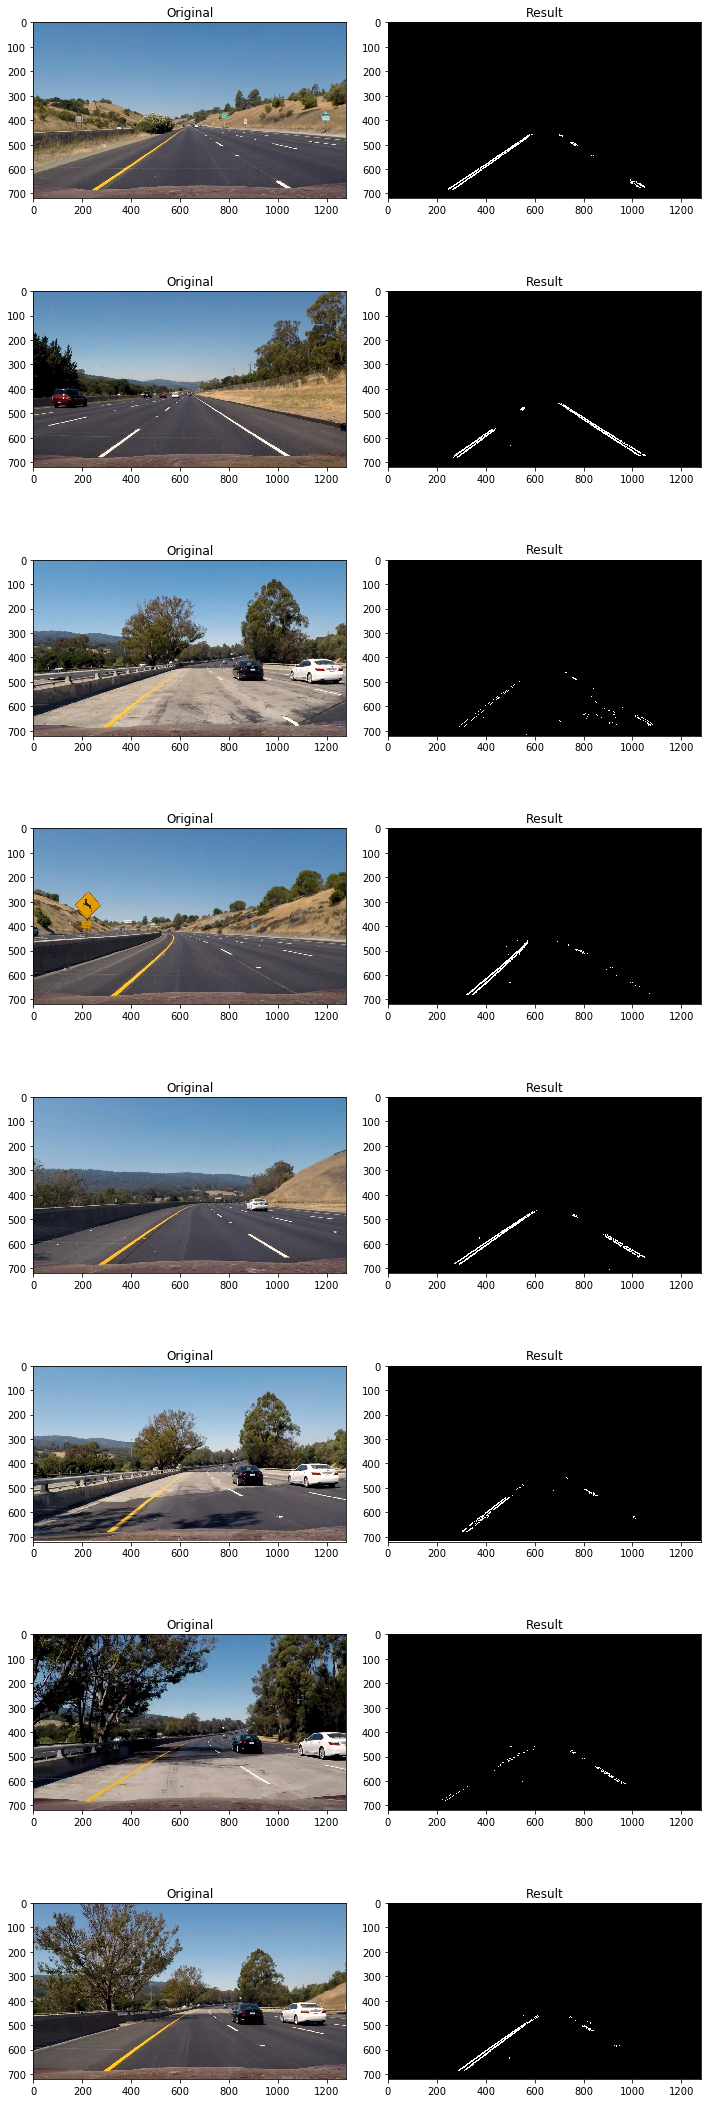

In [6]:
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def magThresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dirThreshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that thresholds the S-channel of HLS
def hlsSelect(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def pipeline(im):
#     img = mpimg.imread(im)
    # use calibtration to undistory img
#     img = undistort(im, objpoints, imgpoints)
    img = im

    # create threshold from s-channel of HLS
    sBinary = hlsSelect(img, thresh=(160, 255))
   
    # add some blur to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # perform sobel thresholds
    ksize = 7
    gradx = absSobelThresh(gray, orient='x', thresh_min=10, thresh_max=255, sobel_kernel=ksize)
#     grady = absSobelThresh(gray, orient='y', thresh_min=60, thresh_max=255, sobel_kernel=ksize)
    magBinary = magThresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dirBinary = dirThreshold(gray, sobel_kernel=ksize, thresh=(0.65, 1.05))
    combined = np.zeros_like(dirBinary)
    combined[((gradx == 1) & (sBinary == 1)) | ((magBinary == 1) & (dirBinary == 1))] = 1
    img = regionOfInterest(combined)
    return img

fig, axs = plt.subplots(8, 2, figsize=(10, 30))
axs = axs.ravel()
fig.tight_layout()

i = 0
for im in glob.glob('./test_images/*.jpg'):
    img = pipeline(mpimg.imread(im))
    axs[i].imshow(mpimg.imread(im))
    axs[i].set_title('Original')
    axs[i + 1].imshow(img, cmap='gray')
    axs[i + 1].set_title('Result')
    i = i + 2
    

# Perspective Transform

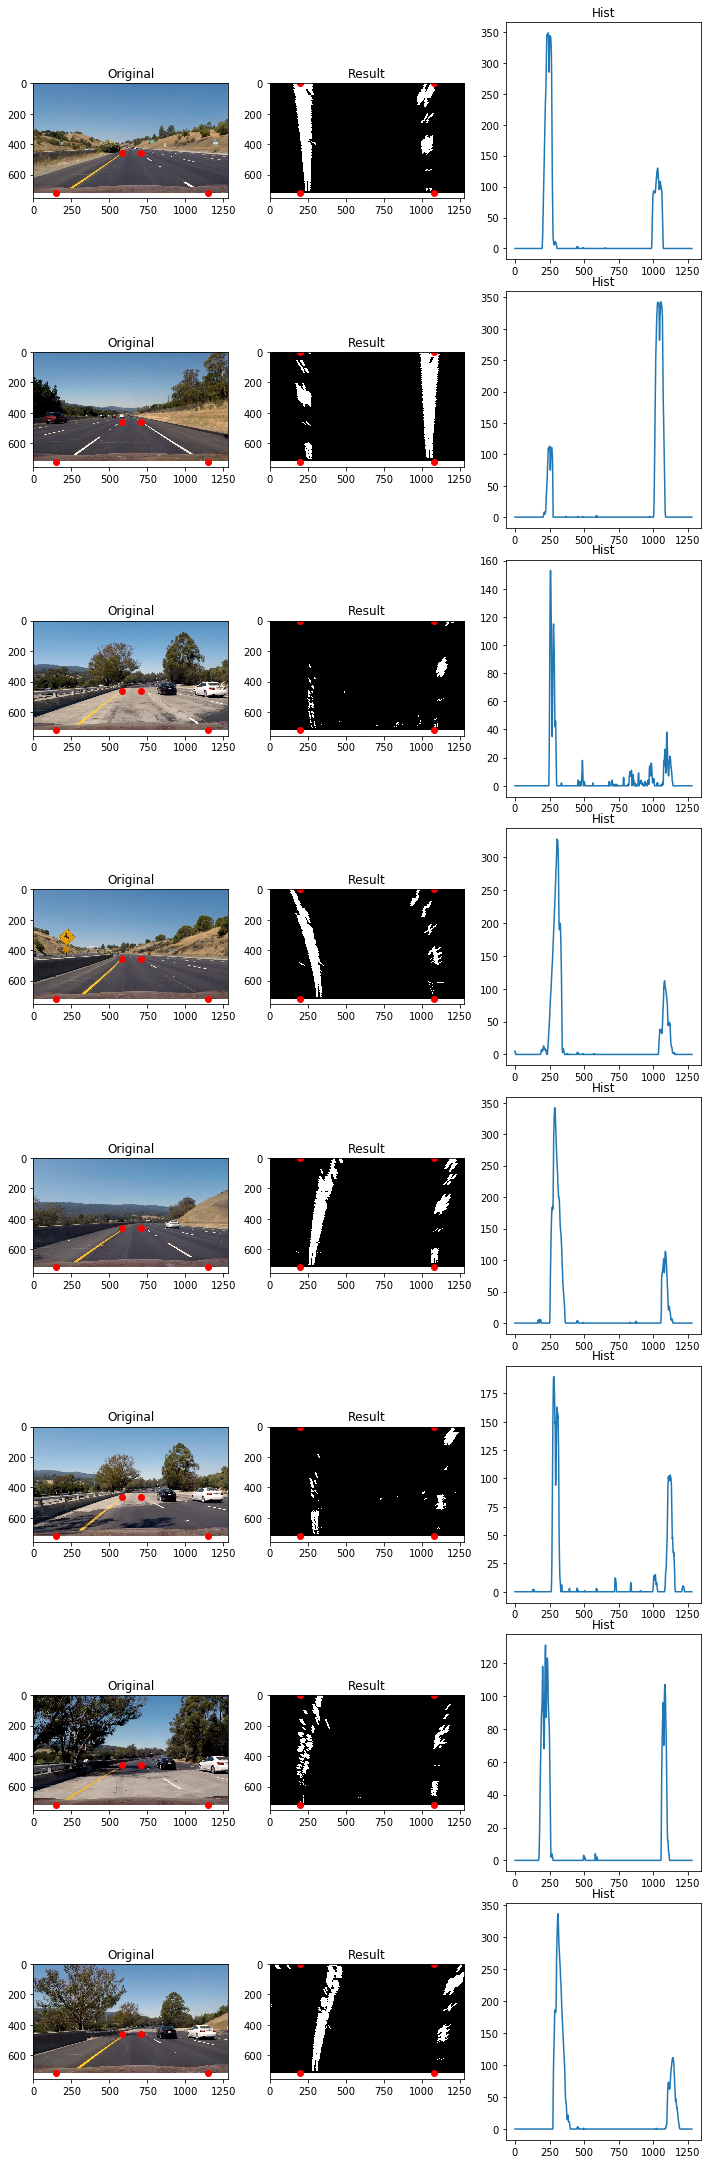

In [7]:
region = np.array([[580, 460],[710, 460],[1150,720],[150,720]])
offset = 200

def perspectiveCorrection(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(region)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, dsize = (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv

fig, axs = plt.subplots(8, 3, figsize=(10, 30))
axs = axs.ravel()
fig.tight_layout()
i = 0

for im in glob.glob('./test_images/*.jpg'):
    img = pipeline(mpimg.imread(im))
    img, M, Minv = perspectiveCorrection(img)
    img[img > 0] = 1
    axs[i].imshow(mpimg.imread(im))
    axs[i].plot(region[:,0], region[:,1], 'ro')
    axs[i].set_title('Original')
    axs[i + 1].imshow(img, cmap='gray')
    axs[i + 1].set_title('Result')
    
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]-offset, img_size[1]], 
                  [offset, img_size[1]]])
        
    axs[i + 1].plot(dst[:,0], dst[:,1], 'ro')
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    axs[i + 2].set_title('Hist')
    axs[i + 2].plot(hist)
    i = i + 3


# Draw Lanes

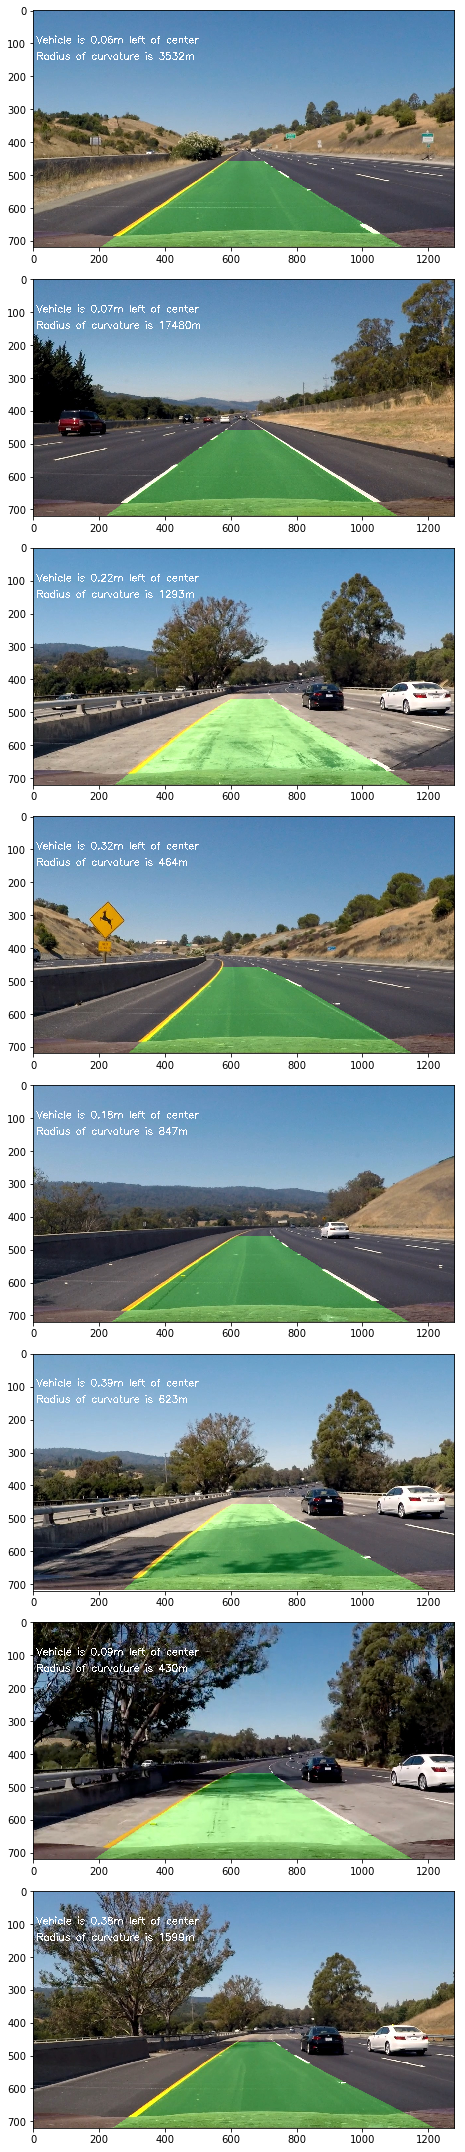

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def sanityCheck(newLeft, newRight, oldLeft, oldRight):
    bottomLeft = newLeft[0]*720**2 + newLeft[1]*720 + newLeft[2]
    bottomRight = newRight[0]*720**2 + newRight[1]*720 + newRight[2]
    topLeft = newLeft[0]*0**2 + newLeft[1]*0 + newLeft[2]
    topRight = newRight[0]*0**2 + newRight[1]*0 + newRight[2]
    
    bottomDistance = bottomRight - bottomLeft
    topDistance = topRight - topLeft
    if (bottomDistance < 750 or bottomDistance > 850):
        return False
    
    if (topDistance < 750 or topDistance > 850):
        return False
    
    return True
    
def drawLanes(binary_warped, img, left, right):
    # Create an output image to draw on and  visualize the result
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    out_img = np.dstack((warp_zero, warp_zero, warp_zero))*255
    leftx = []
    rightx = []
    lefty = []
    righty = []
    if (right.detected and left.detected):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_fit = left.current_fit
        right_fit = right.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        leftFit = np.polyfit(lefty, leftx, 2)
        rightFit = np.polyfit(righty, rightx, 2)
        
        if (sanityCheck(leftFit, rightFit, left.current_fit, right.current_fit) == True):
            left.current_fit = leftFit
            right.current_fit = rightFit
        
    else:

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                left.detected = True
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                right.detected = True
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left.current_fit = np.polyfit(lefty, leftx, 2)
        right.current_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left.current_fit[0]*ploty**2 + left.current_fit[1]*ploty + left.current_fit[2]
    right_fitx = right.current_fit[0]*ploty**2 + right.current_fit[1]*ploty + right.current_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # calc position of vehicle
    bottomLeft = left.current_fit[0]*720**2 + left.current_fit[1]*720 + left.current_fit[2]
    bottomRight = right.current_fit[0]*720**2 + right.current_fit[1]*720 + right.current_fit[2]
    position = (bottomLeft + bottomRight)/2
    dist = abs(img.shape[1]/2 - position)
    font = cv2.FONT_HERSHEY_SIMPLEX
        
    if dist < 640:
        cv2.putText(result,'Vehicle is {:.2f}m left of center'.format(dist*3.7/700),(10,100), font, 1,(255,255,255),2)
    else:
        cv2.putText(result,'Vehicle is {:.2f}m right of center'.format(dist*3.7/700),(10,100), font, 1,(255,255,255),2)

    # curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    y_eval = 720
    
    left_curverad = ((1 + (2*left.current_fit[0]*y_eval + left.current_fit[1])**2)**1.5) / np.absolute(2*left.current_fit[0])
    right_curverad = ((1 + (2*right.current_fit[0]*y_eval + right.current_fit[1])**2)**1.5) / np.absolute(2*right.current_fit[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    cv2.putText(result,'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), (10,150), font, 1,(255,255,255),2)
    
    return result

fig, axs = plt.subplots(8, 1, figsize=(10, 30))
axs = axs.ravel()
fig.tight_layout()
i = 0

for im in glob.glob('./test_images/*.jpg'):
    original = mpimg.imread(im)
    img = pipeline(original)
    right = Line()
    left = Line()
    binary_warped, M, Minv = perspectiveCorrection(img)
    result = drawLanes(binary_warped, original, left, right)

    axs[i].imshow(result)
    i = i + 1
    

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

right = Line()
left = Line()

def process_image(image):
    img = pipeline(image)
    binary_warped, M, Minv = perspectiveCorrection(img)
    result = drawLanes(binary_warped, image, left, right)
    return result


output = 'out.mp4'
# clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4")

challenge_clip = clip1.fl_image(process_image) 
challenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [05:10<00:00,  4.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [34]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('out.mp4'))

In [ ]:
right = Line()
left = Line()

def process_image(image):
    img = pipeline(image)
    binary_warped, M, Minv = perspectiveCorrection(img)
    result = drawLanes(binary_warped, image, left, right)
    return result


output = 'out2.mp4'
clip2 = VideoFileClip("challenge_video.mp4")

challenge_clip2 = clip2.fl_image(process_image) 
challenge_clip2.write_videofile(output, audio=False)